# SD212: Graph mining
## Lab 5: Clustering

You will learn how to cluster the nodes of a graph and to estimate the quality of the clustering. 

## Import

In [1]:
import networkx as nx

The documentation is available [here](https://networkx.readthedocs.io/en/stable/).

In [2]:
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib.pyplot as plt

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

You will need the following datasets (the same as in previous labs, no need to download them again):
* [Les Misérables](http://perso.telecom-paristech.fr/~bonald/graphs/miserables.graphml.gz)<br>  Graph connecting the characters of the [novel of Victor Hugo](https://fr.wikisource.org/wiki/Les_Misérables) when they appear in the same chapter. The graph is undirected and weighted. Weights correspond to the number of chapters in which characters appear together. 
* [Openflights](http://perso.telecom-paristech.fr/~bonald/graphs/openflights.graphml.gz)<br>
Graph of the main international flights. Nodes are airports. The graph is undirected (all flights are bidirectional). Weights correspond to the number of daily flights between airports. Extracted from [Openflights](http://openflights.org).
* [Wikipedia for schools](http://perso.telecom-paristech.fr/~bonald/graphs/wikipedia_schools.graphml.gz)<br> Graph of the hyperlinks between a subset of the pages of the English Wikipedia. The graph is directed and unweighted.
More information [here](https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_for_Schools).
* [Actors-Movies](http://perso.telecom-paristech.fr/~bonald/graphs/actors_movies.graphml.gz)<br>
Graph between actors and movies (a link exists if the actor stars in the movie). The graph is bipartite (see the field 'type' of each node). 
Extracted from [YaGo](http://yago-knowledge.org).

## 1. Modularity

Consider an undirected, unweighted graph of $n$ nodes and $m$ edges with adjacency matrix $A$, without self-loops.

The modularity of clustering $C$ is defined by:
$$
Q(C) = \frac 1 {2m} \sum_{i,j\in V} \left(A_{ij} - \frac {d_id_j}{2m}\right) \delta_{C(i),C(j)}
$$
where $d_i = \sum_j A_{ij}$ is the degree of node $i$.

The modularity can also be written:
$$
Q(C) = \sum_k  \frac{m_k}{m} - \sum_k  \left( \frac{v_k}{v}\right)^2
$$
where
* $m_k$ is the number of edges in cluster $k$  
* $v_k $ is the volume of cluster $k$ (total degree of nodes in the cluster)
* $v$ is the volume of the graph (total degree of nodes)

The definition extends to a weighted graph as follows:
$$
Q(C) = \sum_k  \frac{w_k}{w} - \sum_k  \left( \frac{v_k}{v}\right)^2
$$
where
* $w_k$ is the weight of cluster $k$ (total weight of edges in the cluster)
* $w$ is the weight of the graph (total weight of edges in the graph)

## Toy graph

Consider the following graph:

In [70]:
edges = [(7,5),(5,3),(3,7),(4,5),(8,6),(7,4),(1,6),(9,8),(7,8),(6,1),(2,9),(8,2),(1,9)]
graph = nx.Graph()
graph.add_edges_from(edges)

with the following clustering:

In [71]:
C = {1: 0, 2: 0, 6: 0, 8: 0, 9: 0, 3: 1, 4: 1, 5: 1, 7: 1}

Visualization:

In [72]:
pos = nx.spring_layout(graph)

In [73]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [74]:
node_colors = [colors[C[u] % len(colors)] for u in graph.nodes()]

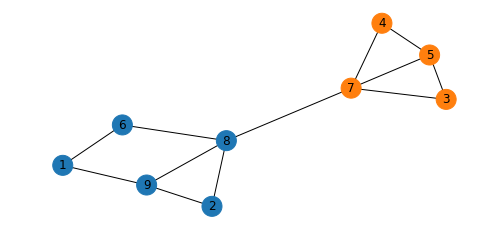

In [75]:
plt.figure(figsize = (6,3))
nx.draw(graph, pos, node_size = 400, node_color = node_colors, with_labels = True)
plt.show()

## To do

* What is the fraction of edges within clusters?
* What is the Simpson's index associated with the volume distribution between clusters?
* Deduce the modularity of the clustering. 
* What is the maximum value of modularity for 2 clusters?
* Complete the function `get_modularity` below and check it on the above graph.

In [12]:
11/12

0.9166666666666666

In [76]:
def simpson(graph, C):
    v_k = {}
    
    for node in graph:
        v_k[C[node]] = graph.degree[node] + v_k.get(C[node], 0)
    
    v = len(graph.edges) * 2
    
    return sum([v_i**2/(v**2) for v_i in v_k.values()])

In [77]:
simpson(graph,C)

0.5034722222222222

In [79]:
11/12 - simpson(graph,C)

0.4131944444444444

Max = 1/2 :
Simpson est minoré par 1/K K le nombre de cluster

et Le premier term est maj par 1 (C'est atteignable pour 2 clusteur parfait : 2 composantes connexes

In [80]:
def get_modularity(graph,C):
    '''
    graph: networkx graph
        undirected graph (possibly weighted)
    C: dictionary
        cluster of each node
        
    Returns: float
        modularity
    '''
    
    # add weights if none
    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1
            
    clusters = set(C.values())
    cluster_weight = {k: 0 for k in clusters}
    cluster_volume = {k: 0 for k in clusters}
    Q = 0
    
    node_weight = {u: 0. for u in graph.nodes()}
    w = 0
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
        w += graph[u][v]['weight']
    
    v = 2 * w
    
    weights = nx.get_edge_attributes(graph,'weight')
    
    for node in graph:
        cluster_volume[C[node]] += node_weight[node]
    
    for edge in graph.edges:
        c = C[edge[0]]
        if c != C[edge[1]]:
            continue
        
        cluster_weight[c] += weights[edge]
    

    return sum([w_k/w for w_k in cluster_weight.values()]) - sum([v_k**2/(v**2) for v_k in cluster_volume.values()])

In [81]:
get_modularity(graph, C)

0.41319444444444453

## Stochastic block model

The [stochastic block model](https://en.wikipedia.org/wiki/Stochastic_block_model) is a random graph with an underlying structure in clusters (the blocks).

In [82]:
block_sizes = [10, 15, 20]
p_in = 0.4 # probability of connection within blocks
p_out = 0.02 # probability of connection across blocks
graph = nx.random_partition_graph(sizes = block_sizes, p_in = p_in, p_out = p_out,seed = 0)
pos = nx.spring_layout(graph)

In [83]:
pos = nx.spring_layout(graph)

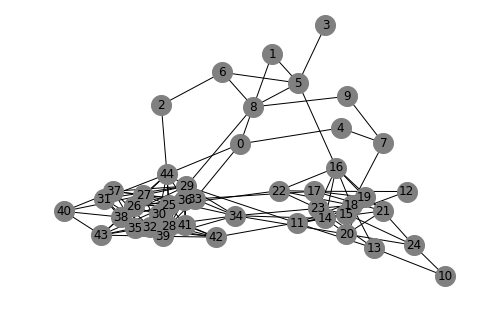

In [84]:
plt.figure(figsize = (6,4))
nx.draw(graph, pos, node_size = 400, node_color = 'gray', with_labels = True)
plt.show()

## To do

* Propose a clustering for this graph and compute the modularity.
* What is the strongest cluster? 
* Complete the function `get_cluster_strength` below and check your guess.
* Comment the results.

**Hint:** Recall that the strength of cluster $k$ is defined by: $$\frac{2w_k }{ v_k}.$$

3 clusters évidents. Le plus fort est le 3eme

In [85]:
C = {u:0 for u in graph}
for node in graph:
    if node > 9:
        if node < 25:
            C[node] = 1
        else:
            C[node] = 2
        continue

In [86]:
node_colors = [colors[C[u] % len(colors)] for u in graph.nodes()]

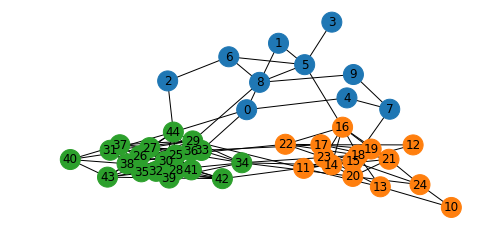

In [87]:
plt.figure(figsize = (6,3))
nx.draw(graph, pos, node_size = 400, node_color = node_colors, with_labels = True)
plt.show()

In [96]:
def get_cluster_strength(graph,C):
    '''
    graph: networkx graph
        undirected graph (possibly weighted)
    C: dictionary
        cluster of each node
        
    Returns: dictionary
        strength of each cluster
    '''
    
    # add weights if none
    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1
    
    clusters = set(C.values())
    cluster_weight = {k: 0 for k in clusters}
    cluster_volume = {k: 0 for k in clusters}
    cluster_strength = {k: 0 for k in clusters}
    
    weights = nx.get_edge_attributes(graph,'weight')
    
    node_weight = {u: 0. for u in graph.nodes()}
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
    
    for node in graph:
        cluster_volume[C[node]] += node_weight[node]
    
    for edge in graph.edges:
        c = C[edge[0]]
        if c == C[edge[1]]:
            cluster_weight[c] += weights[edge]
        
    
    cluster_strength = {k: 2*cluster_weight[k]/cluster_volume[k] for k in clusters}
    
    return cluster_strength

In [97]:
get_cluster_strength(graph,C)

{0: 0.8, 1: 0.8941176470588236, 2: 0.9349112426035503}

In [90]:
get_modularity(graph, C)

0.4536054354294783

## 2. The Louvain algorithm

The Louvain algorithm attempts to maximize modularity as follows:
1. **(Initialization)** $C \gets \text{identity}$ 
2.  **(Maximization)** While modularity increases, update $C$ by moving one node  from its cluster to one of its neighbors
3. **(Aggregation)** Merge all nodes belonging to the same cluster into a single node, update the weights accordingly and apply step 2 to the  aggregate graph

In step 2, nodes are considered in a cyclic way. The target cluster of a node is chosen among  its neighbors as that providing the **largest gain** in modularity, if any.

## To do

* Complete the function `maximize_modularity` corresponding to step 2.
* Test your `louvain` function on the stochastic block model.
* Test different resolution parameters.

In [106]:
def maximize_modularity(graph, resolution):
    '''
    graph: networkx graph
        undirected graph 
    resolution: float
        resolution parameter (positive)
        
    Returns: dictionary
        cluster of each node
    '''

    node_weight = {u: 0. for u in graph.nodes()}
    w = 0
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
        w += graph[u][v]['weight']
    # init the clustering
    C = {u:u for u in graph.nodes()}
    # cluster weights
    cluster_weight = {u: node_weight[u] for u in graph.nodes()}
    # node-cluster weights (between each node and the clusters)
    node_cluster_weight = {u:{v: 1. * graph[u][v]['weight'] for v in graph.neighbors(u) if v != u} 
                           for u in graph.nodes()}
    increase = True
    while increase:
        increase = False
        for u in graph.nodes():
            k = C[u]            
            if k not in node_cluster_weight[u]:
                node_cluster_weight[u][k] = 0
            variation = {k: 0}
            
            neighbors_clusters = set([C[v] for v in graph.neighbors(u)])
            
            variation = {
                l: node_cluster_weight[u][l] - node_cluster_weight[u][k] - resolution * \
                node_weight[u] * (cluster_weight[l] - cluster_weight[k] + node_weight[u])/(2*w)
                for l in node_cluster_weight[u]}
            
            l = max(variation, key = variation.get)
            if variation[l] > 0:
                increase = True
                # move node u from cluster k to cluster l
                C[u] = l
                cluster_weight[k] -= node_weight[u]
                cluster_weight[l] += node_weight[u]
                for v in graph.neighbors(u):
                    if v != u:
                        node_cluster_weight[v][k] -= graph[u][v]['weight']
                        if node_cluster_weight[v][k] <= 0:
                            node_cluster_weight[v].pop(k)
                        if l not in node_cluster_weight[v]:
                            node_cluster_weight[v][l] = 0
                        node_cluster_weight[v][l] += graph[u][v]['weight']
    return C

In [107]:
def aggregate_graph(graph,C):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
        
    Returns: networkx graph
        aggregate graph with one node per cluster
    '''

    aggregate_graph_ = nx.Graph()
    aggregate_graph_.add_nodes_from(set(C.values()))
    for u,v in graph.edges():
        if aggregate_graph_.has_edge(C[u],C[v]):
            aggregate_graph_[C[u]][C[v]]['weight'] += graph[u][v]['weight']
        else:
            aggregate_graph_.add_edge(C[u],C[v])
            aggregate_graph_[C[u]][C[v]]['weight'] = graph[u][v]['weight']
    return aggregate_graph_

In [108]:
def louvain(graph,resolution = 1):
    '''
    graph: networkx graph
        undirected graph 
    resolution: float
        resolution parameter (positive)
        
    Returns: dictionary
        cluster of each node
    '''

    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1

    C = maximize_modularity(graph, resolution)
    n = len(C)
    k = len(set(C.values()))
    while k < n:
        aggregate_graph_ = aggregate_graph(graph,C) 
        C_new = maximize_modularity(aggregate_graph_, resolution)
        C = {u: C_new[C[u]] for u in graph.nodes()}
        n = k
        k = len(set(C_new.values()))
    # reindex clusters in decreasing order of size
    clusters = list(set(C.values()))
    cluster_size = {k: 0 for k in clusters}
    for u in C:
        cluster_size[C[u]] += 1
    cluster_index = sorted(cluster_size, key = cluster_size.get, reverse = True)
    reindex = {k:i for i,k in enumerate(cluster_index)}
    C = {u:reindex[C[u]] for u in C}
    return C

In [119]:
C = louvain(graph, 1)

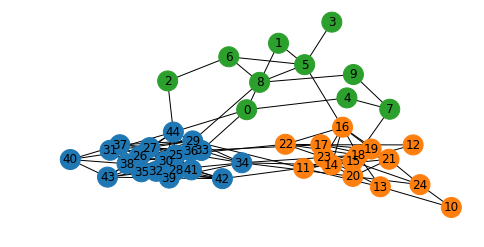

In [120]:
node_colors = [colors[C[u] % len(colors)] for u in graph.nodes()]

plt.figure(figsize = (6,3))
nx.draw(graph, pos, node_size = 400, node_color = node_colors, with_labels = True)
plt.show()

## Real data

The function `get_clusters` below returns the clusters as lists of nodes in decreasing order of weight.

In [121]:
def get_clusters(graph, C):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
        
    Returns: dictionary of lists
        for each cluster, nodes are listed in decreasing order of weight
    '''

    if nx.get_edge_attributes(graph,'weight') == {}:
        for u,v in graph.edges():
            graph[u][v]['weight'] = 1

    node_weight = {u: 0 for u in graph.nodes()}
    for u,v in graph.edges():
        node_weight[u] += graph[u][v]['weight']
        node_weight[v] += graph[u][v]['weight']
        
    clusters = list(set(C.values()))
    cluster_nodes = {k:{} for k in clusters}
    for u in graph.nodes():
        cluster_nodes[C[u]][u] = node_weight[u]

    cluster_nodes = {k: sorted(cluster_nodes[k], key = cluster_nodes[k].get, reverse = True)
                             for k in clusters}
        
    return cluster_nodes

In [123]:
get_clusters(graph, C)

{0: [29,
  32,
  35,
  36,
  38,
  39,
  44,
  41,
  25,
  26,
  27,
  28,
  33,
  34,
  37,
  42,
  43,
  30,
  31,
  40],
 1: [14, 15, 23, 16, 18, 19, 17, 20, 21, 11, 22, 13, 24, 10, 12],
 2: [8, 5, 0, 6, 7, 1, 2, 4, 9, 3]}

## To do

* List the top-3 characters of each cluster of Les Miserables (resolution 1).
* List the top-3 airports of each cluster of Openflights (resolutions 1 and 2); visualize the clusters, with the associate top airports.
* List the top-5 pages of the 20 largest clusters of Wikipedia for Schools (resolution 2). Compare the results obtained when the graph is considered as undirected and bipartite.
* List the top-5 actors in the cluster of **Marion Cotillard** in the actors-movies graph (resolution 10).

**Note:** You may compute the size and strength of each cluster.

In [131]:
miserables = nx.read_graphml("../miserables.graphml", node_type = int)

C = louvain(miserables)
top = get_clusters(miserables, C)
{c: list(map(lambda x: miserables.nodes[x]['name'], top[c]))[:3] for c in top}

{0: ['Valjean', 'Marius', 'Cosette'],
 1: ['Enjolras', 'Courfeyrac', 'Combeferre'],
 2: ['Myriel', 'Mme Magloire', 'Mlle Baptistine'],
 3: ['Thenardier', 'Mme Thenardier', 'Babet'],
 4: ['Fantine', 'Tholomyes', 'Favourite'],
 5: ['Judge', 'Champmathieu', 'Brevet']}

In [175]:
openflights = nx.read_graphml("../openflights.graphml", node_type = int)

C = louvain(openflights, 1)
top = get_clusters(openflights, C)
{c: list(map(lambda x: openflights.nodes[x]['name'], top[c]))[:3] for c in top}

{0: ['Hartsfield Jackson Atlanta International Airport',
  'Dallas Fort Worth International Airport',
  "Chicago O'Hare International Airport"],
 1: ['Beijing Capital International Airport',
  'Shanghai Pudong International Airport',
  'Chek Lap Kok International Airport'],
 2: ['Amsterdam Airport Schiphol',
  'Charles de Gaulle International Airport',
  'Dublin Airport'],
 3: ['Atatürk International Airport',
  'Dubai International Airport',
  'OR Tambo International Airport'],
 4: ['Guarulhos - Governador André Franco Montoro International Airport',
  'El Dorado International Airport',
  'Viracopos International Airport'],
 5: ['Sydney Kingsford Smith International Airport',
  'Port Moresby Jacksons International Airport',
  'Melbourne International Airport'],
 6: ['Domodedovo International Airport',
  'Sheremetyevo International Airport',
  'Pulkovo Airport'],
 7: ['Ted Stevens Anchorage International Airport',
  'Nome Airport',
  'Bethel Airport'],
 8: ['Quebec Jean Lesage Internat

In [176]:
# Get positions
pos_x = nx.get_node_attributes(openflights,'pos_x')
pos_y = nx.get_node_attributes(openflights,'pos_y')
pos = {u: (pos_x[u], pos_y[u]) for u in openflights}

In [177]:
node_colors = [colors[C[u] % len(colors)] for u in openflights.nodes()]

top_airports = reduce(lambda x,y: x+y, [top[c][:3] for c in top])
tclusters = get_clusters(wikipedia_b, C)
top_clusterop_colors = [colors[C[u] % len(colors)] for u in top_airports]

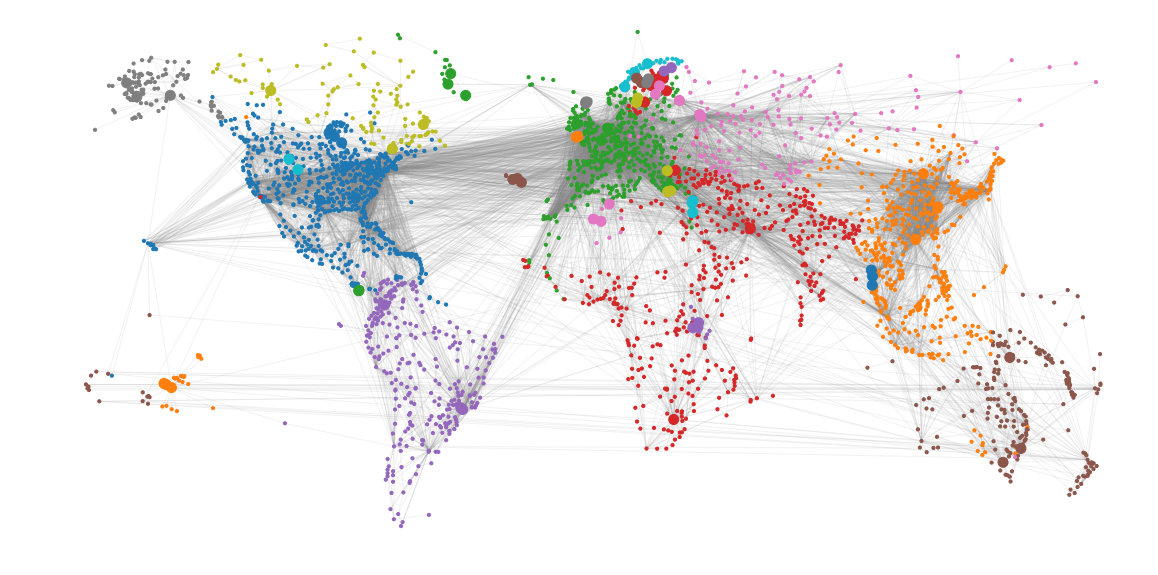

In [178]:
plt.figure(figsize=(20,10))
plt.axis('off')
nx.draw_networkx_nodes(openflights, pos, node_size = 10, node_color = node_colors)
nx.draw_networkx_nodes(openflights, pos, node_size = 100, nodelist = top_airports, node_color = top_colors)
nx.draw_networkx_edges(openflights, pos, alpha = .1, edge_color = 'grey')
plt.show()

In [193]:
wikipedia = nx.read_graphml("../wikipedia_schools.graphml", node_type = int)

wikipedia_u = wikipedia.to_undirected()

C = louvain(wikipedia_u, 2)

clusters = get_clusters(wikipedia_u, C)
top_clusters = sorted(clusters, key = lambda x: len(clusters[x]), reverse = True)[:20]

from pprint import pprint

pprint({c: list(map(lambda x: wikipedia_u.nodes[x]['name'], clusters[c]))[:5] for c in top_clusters})

{0: ['Europe',
     'Africa',
     'Scientific classification',
     'Animal',
     'North America'],
 1: ['Earth', 'Water', 'Gold', 'Iron', 'Sun'],
 2: ['United Kingdom', 'England', 'London', 'Scotland', 'Ireland'],
 3: ['Italy', 'Paris', 'Roman Catholic Church', 'Philosophy', 'Ancient Greece'],
 4: ['United States',
     'New York City',
     'California',
     'Washington, D.C.',
     'United States dollar'],
 5: ['Agriculture', 'Human', 'Plant', 'Rice', 'Medicine'],
 6: ['Spain', 'Mexico', 'Brazil', 'Atlantic Ocean', 'Argentina'],
 7: ['Japan', 'Television', 'Film', 'Internet', 'Radio'],
 8: ['United Nations', 'Time zone', 'Turkey', 'Portugal', 'Currency'],
 9: ['Germany', 'World War II', 'Russia', 'World War I', 'Soviet Union'],
 10: ['Egypt', 'Christianity', 'Israel', 'Islam', 'Jew'],
 11: ['India', 'China', "People's Republic of China", 'Pakistan', 'Vietnam'],
 12: ['Australia', 'New Zealand', 'Indonesia', 'Pacific Ocean', 'Philippines'],
 13: ['Volcano', 'River', 'Iceland', 'An

In [194]:
def bipartite_from_directed(graph):
    '''
    graph: networkx graph
        directed graph 
        
    Returns: networkx graph
        undirected, bipartite graph
    '''    
    new_graph = nx.Graph()
    nodes = list(graph.nodes())
    if nodes == list(np.arange(len(nodes))):
        new_graph.add_nodes_from(nodes)
        new_graph.add_nodes_from(list(np.arange(-len(nodes),0)))
        edges = [(u,-v-1) for u,v in graph.edges()]
        new_graph.add_edges_from(edges)
    else:
        print('Nodes must be indexed from 0 to n-1.')
    return new_graph

In [201]:
wikipedia_b = bipartite_from_directed(wikipedia)

C = louvain(wikipedia_b, 2)

clusters = get_clusters(wikipedia_b, C)
top_clusters = sorted(clusters, key = lambda x: len(clusters[x]), reverse = True)[:20]

from pprint import pprint

pprint({c: list(map(lambda x: wikipedia.nodes[abs(x)]['name'], clusters[c]))[:5] for c in top_clusters})

{0: ['Holy Roman Empire', 'Aarhus', 'Apple', 'Dominica', 'Novel'],
 1: ['Lion', 'Olympic Games', 'Wales', 'Isle of Man', 'Ireland'],
 2: ['Planet', 'Earth', 'Probability theory', 'Mount St. Helens', 'Water'],
 3: ['Vatican City',
     'English language',
     'New Zealand',
     'East Timor',
     'Washington, D.C.'],
 4: ['Phase (matter)',
     'Planetary habitability',
     'Akbar',
     'Hawking radiation',
     'Israel'],
 5: ['Plato', 'Richard Wagner', 'Denmark', 'History of science', 'Human'],
 6: ['Khazars', 'Crusades', 'John of England', 'Petroleum', 'Iraq'],
 7: ['John Calvin',
     'Tobacco smoking',
     '21st century',
     'Integrated circuit',
     'Jazz'],
 8: ['Rice',
     'Euro',
     'Driving on the left or right',
     'Nationality',
     'List of countries'],
 9: ['Elizabeth I of England', 'United States', 'U2', 'Antarctica', 'Libya'],
 10: ['Edouard Manet', 'Impressionism', 'Stockholm', 'Zionism', 'Spain'],
 11: ['Banknote', 'Pyrite', 'Eye', 'Abhidhamma Pitaka', 'V

In [209]:
actors_movies = nx.read_graphml("../actors_movies.graphml", node_type = int)
marion_cotillard = 5172


C = louvain(actors_movies, 10)
clusters = get_clusters(actors_movies, C)
clusters[C[marion_cotillard]][:5]

[405, 2866, 2865, 15566, 6234]

In [210]:
list(map(lambda x: actors_movies.nodes[x]['name'], clusters[C[marion_cotillard]][:5]))

['Gérard Depardieu',
 'Isabelle Huppert',
 'Catherine Deneuve',
 'Jean-Louis Trintignant',
 'Philippe Noiret']

## 3. Soft clustering

We have so far considered **hard clustering** where the objective is to find a partition of the set of nodes. In practice, it may be interesting to allow some nodes to belong to several clusters. This is **soft clustering**. A simple approach consists in identifying so-called flipping nodes, for which a change of cluster has a negligible impact on modularity (for some given threshold). 

## To do

* Complete the function `get_flipping_nodes` below.
* Test your function on the bow-tie graph.
* Display the airports belonging to several clusters in Openflights (resolutions 1 and 2).

In [ ]:
def get_flipping_nodes(graph, C, resolution = 1, threshold = 1e-5):
    '''
    graph: networkx graph
        undirected graph 
    C: dictionary
        cluster of each node
    resolution: float
        resolution parameter 
    threshold: float
        threshold on modularity 
        
    Returns: dictionary of lists
        list of clusters of each flipping node (i.e., with more than 1 cluster)
    '''

    flipping_nodes = {}
    # to be completed
    return flipping_nodes 

In [ ]:
bowtie = nx.star_graph(4)
bowtie.add_edges_from([(1,2),(3,4)])

In [ ]:
plt.figure(figsize = (6,3))
nx.draw(bowtie, node_size = 400, with_labels = True)
plt.show()